In [1]:
# Import
%reset -f
import utils as ut
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm  # Colormaps
from matplotlib.colors import LogNorm  # Log colormaps
import datetime as DT
import pandas as pd
import math
import scipy
from IPython.core.debugger import Tracer

from sklearn import datasets, linear_model
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
#from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline
import seaborn as sns; sns.set()
import operator
import itertools
import matplotlib.patches as mpatches
from scipy.stats.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')
ut.init()
#Tracer()()

Using Theano backend.


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
#formatting
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
#filename = './data/international-airline-passengers.csv'
filename = './data/futs_us.csv'


In [5]:
def calcmse (x, y):
    #Predictor comparison
    res = x - y
    res_e = np.sqrt(np.mean(res**2))
    #print(res_e)
    return res_e, res

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
def stripoutrepeats(d):
    cur = np.nan
    ret = []
    for v in d:
        #print(cur)
        if not math.isclose(cur, v, rel_tol=1e-5):
            ret.append(v)
            cur = v
    return np.asarray(ret)
def diff(d):
    ret = d - np.roll(d, 1)
    ret[0] =0
    return ret


diff([1,2,3,4,5])
diff([1,1,1,2,-3,4,4,3,2,6,10])
stripoutrepeats([1,1,1,2,1,2,2,4,5,5,5])

v1 = [1,3,2,2,1,2,2,4,5,5,5]
v1
diff(v1)
v2 = np.roll(-diff(v1), 1)
v2

array([0, 1, 1, 1, 1])

array([ 0,  0,  0,  1, -5,  7,  0, -1, -1,  4,  4])

array([1, 2, 1, 2, 4, 5])

[1, 3, 2, 2, 1, 2, 2, 4, 5, 5, 5]

array([ 0,  2, -1,  0, -1,  1,  0,  2,  1,  0,  0])

array([ 0,  0, -2,  1,  0,  1, -1,  0, -2, -1,  0])

In [8]:
# LSTM for international airline passengers problem with regression framing
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv(filename, usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
limit = 10000
if True:
    dataset = stripoutrepeats(dataset)
if True:
    dataset = diff(dataset)

dataset = dataset[:min(len(dataset),limit)]
sequence = list(range(len(dataset)))
dataset[:3]
sequence = np.array([[sequence[x]] for x in range(len(sequence))])
sequence[:3]

array([[ 0.      ],
       [-0.015625],
       [ 0.015625]], dtype=float32)

array([[0],
       [1],
       [2]])

In [9]:
def windowdata(x, y, train_len, test_len, from_start=False):
    start_train = 0
    end_train = start_train + train_len
    start_real = 0
    
    it = 0
    max = 2000
    while end_train < len(x):
        if it >= max:
            break
        end_train = np.min([start_train + train_len, len(x)])
        end_test = end_train + test_len
        l1 = len(x) - end_train
        if l1 ==0:
            break
       
        x1 = x[start_real:end_train,:]
        y1 = y[start_real:end_train]
        x2 = x[end_train:end_test,:]
        y2 = y[end_train:end_test]
        print("Window: ", it, x1.shape, y1.shape, x2.shape, y2.shape)
        yield x1, y1, x2, y2
        start_train += test_len
        if not from_start:
            start_real += test_len
        it += 1



In [10]:
def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.
    This is a fast approximation of re-initializing the weights of a model.
    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    model.set_weights(weights)

(6700, 3300)

Window:  0 (200, 10) (200,) (10, 10) (10,)
- 16.7575 s -
Window:  1 (200, 10) (200,) (10, 10) (10,)
- 5.2341 s -
Window:  2 (200, 10) (200,) (10, 10) (10,)
- 5.2290 s -
Window:  3 (200, 10) (200,) (10, 10) (10,)
- 5.2176 s -
Window:  4 (200, 10) (200,) (10, 10) (10,)
- 5.2156 s -
Window:  5 (200, 10) (200,) (10, 10) (10,)
- 5.2264 s -
Window:  6 (200, 10) (200,) (10, 10) (10,)
- 5.2483 s -
Window:  7 (200, 10) (200,) (10, 10) (10,)
- 5.2527 s -
Window:  8 (200, 10) (200,) (10, 10) (10,)
- 5.2181 s -
Window:  9 (200, 10) (200,) (10, 10) (10,)
- 5.2372 s -
Window:  10 (200, 10) (200,) (10, 10) (10,)
- 5.2598 s -
Window:  11 (200, 10) (200,) (10, 10) (10,)
- 5.3762 s -
Window:  12 (200, 10) (200,) (10, 10) (10,)
- 5.3882 s -
Window:  13 (200, 10) (200,) (10, 10) (10,)
- 5.7172 s -
Window:  14 (200, 10) (200,) (10, 10) (10,)
- 5.3218 s -
Window:  15 (200, 10) (200,) (10, 10) (10,)
- 5.1823 s -
Window:  16 (200, 10) (200,) (10, 10) (10,)
- 5.2123 s -
Window:  17 (200, 10) (200,) (10, 10) (1

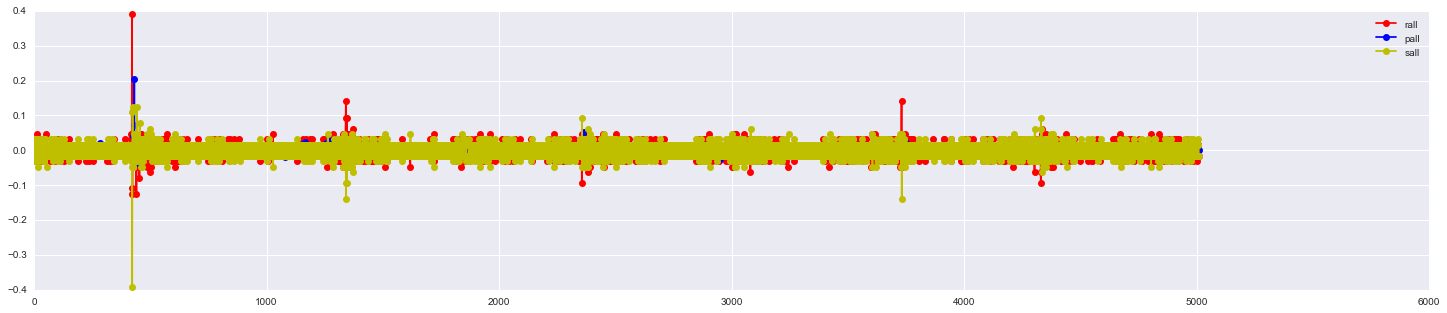

In [17]:
look_back = 10
final_split = 0.67
# split into train and test sets
train_size = int(len(dataset) * final_split)
test_size = len(dataset) - train_size
train_size, test_size
_1, _2 = create_dataset(dataset, look_back)
num_lstm = 4
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(num_lstm, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
    
#_3, _4 = create_dataset(index, 2)
from_start = False
win_size = 200
win_step = 10
i = 0
pall = []
rall = []
t = ut.timeit()
i_max = 500
for x1, y1, x2, y2 in windowdata(_1, _2, win_size, win_step, from_start=from_start):
    p1, r1 = runonewindow(x1, y1, x2, y2, model, doplot=False, debug=False, nb_epoch=30)
    t.ptime()
    pall = np.append(pall, p1)
    rall = np.append(rall, r1)
    if i >= i_max:
        break
    i+=1
    #"y1",y1[:3]
    #"x2",x2[:3]
    #"y2",y2[:3]

sall = np.roll(rall,1)
sall[0] = sall[1]

nall = np.zeros(len(rall))
#simpletestY
mrall = np.roll(-rall, 1)
mrall[0] = 0

te_e, te_e_ar = calcmse(rall, pall)
si_e, si_e_ar = calcmse(rall, mrall)
#si_e, si_e_ar = calcmse(rall, sall)

print('Total RMSE')
print(look_back, num_lstm, win_size, win_step, i_max)
print ('Test Score: %.4f RMSE' % (te_e))
print ('Simple Score: %.4f RMSE' % (si_e))

#print ('Train Score: %.4f RMSE' % (tr_e))
    
ut.figurefullwidth()
plt.plot(rall,'-o', c='r',label='rall')
plt.plot(pall,'-o', c='b',label='pall')
plt.plot(mrall,'-o', c='y',label='sall')
plt.legend(loc='best')


In [16]:
rall[:15]
pall[:10]
mrall[:10]
diff(rall)[:10]
#np.roll(-diff(rall), 1)

array([-0.015625,  0.03125 ,  0.015625,  0.015625,  0.015625, -0.03125 ,  0.015625,  0.015625, -0.015625, -0.03125 , -0.015625,  0.03125 ,  0.03125 ,
       -0.03125 ,  0.046875])

array([ 0.00411971,  0.00848977, -0.00899157,  0.00016247, -0.00010876, -0.0001605 ,  0.00282718, -0.00377606,  0.00438398, -0.00041206])

array([ 0.      ,  0.015625, -0.03125 , -0.015625, -0.015625, -0.015625,  0.03125 , -0.015625, -0.015625,  0.015625])

array([ 0.      ,  0.046875, -0.015625,  0.      ,  0.      , -0.046875,  0.046875,  0.      , -0.03125 , -0.015625])

In [ ]:
    Total RMSE
3 4 100 2 100
Test Score: 0.0137 RMSE
Simple Score: 0.0120 RMSE
    Total RMSE
3 4 100 10 10
Test Score: 0.0126 RMSE
Simple Score: 0.0112 RMSE
    Total RMSE
10 4 100 10 10
Test Score: 0.0156 RMSE
Simple Score: 0.0112 RMSE
    Total RMSE
10 6 100 10 10
Test Score: 0.0129 RMSE
Simple Score: 0.0112 RMSE
    Total RMSE
10 2 100 10 10
Test Score: 0.0135 RMSE
Simple Score: 0.0112 RMSE
    Total RMSE
3 2 100 5 20
Test Score: 0.0124 RMSE
Simple Score: 0.0114 RMSE
    Total RMSE
50 6 500 10 100
Test Score: 0.0760 RMSE
Simple Score: 0.0189 RMSE

In [12]:
def runonewindow(trainX, trainY, testX, testY, model, doplot=True, debug=True, nb_epoch=10):
    
    if doplot:
        ut.figurefullwidth()
        ut.subplot(1)
        ut.subplottitle(1,"train")
        plt.plot(trainY)
        ut.subplot(2)
        ut.subplottitle(2,"test")
        plt.plot(testY)
        plt.show()
    realY = testY
    orig = np.append(trainY, testY)
    # normalize the dataset
    scalerx = MinMaxScaler(feature_range=(0, 1))
    scalery = MinMaxScaler(feature_range=(0, 1))
    #dataset = scaler.fit_transform(dataset)
    
    trainX = scalerx.fit_transform(trainX)
    trainY = scalery.fit_transform(trainY)
    testX = scalerx.transform(testX)
    testY = scalery.transform(testY)
    #print(ut.unprep(trainY)[:10])
    #print(ut.unprep(testY)[:10])
    #print(type(trainY))
    #print(orig)
    #return
    inputdim = trainX.shape[1]
    datalen = len(trainX) + len(testX)
    if debug:
        print("datalen", datalen)
        print('Shapes Train: ',trainX.shape , trainY.shape)
        print('Shapes Test: ',testX.shape , testY.shape)
    # reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    #testY
    #test
    #testX, testY
    #trainX
    
    #shuffle weights rather than recompile
    shuffle_weights(model)
    model.fit(trainX, trainY, nb_epoch=nb_epoch, batch_size=1, verbose=0)
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scalery.inverse_transform(trainPredict)
    trainY = scalery.inverse_transform([trainY])
    testPredict = scalery.inverse_transform(testPredict)
    testY = scalery.inverse_transform([testY])
    #testY[0]
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    if debug:
        print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    if debug:
        print('Test Score: %.2f RMSE' % (testScore))
    if doplot:
        # shift train predictions for plotting
        trainPredictPlot = numpy.empty((datalen,1))
        trainPredictPlot[:,:] = numpy.nan
        trainPredictPlot[:len(trainPredict), :] = trainPredict
        # shift test predictions for plotting
        testPredictPlot = numpy.empty((datalen,1))
        testPredictPlot[:, :] = numpy.nan
        testPredictPlot[len(trainPredict):datalen, :] = testPredict
        # plot baseline and predictions
        ut.figurefullwidth()
        plt.plot(orig, '-o', label='orig')
        plt.plot(trainPredictPlot, '-o',label='train')
        plt.plot(testPredictPlot,'-o',label='test')
        plt.legend(loc='best')
        plt.show()
        #trainPredictPlot
        #testPredictPlot

    simpletestY = np.roll(testY[0],1)
    simpletestY[0] = simpletestY[1]
    #simpletestY

    tr_e, tr_e_ar = calcmse(trainY[0], trainPredict[:,0])
    te_e, te_e_ar = calcmse(testY[0], testPredict[:,0])
    si_e, si_e_ar = calcmse(testY[0], simpletestY)
    
    if debug:
        print ('Test Score: %.4f RMSE' % (te_e))
        print ('Simple Score: %.4f RMSE' % (si_e))

        print ('Train Score: %.4f RMSE' % (tr_e))
    if doplot:
        ut.figurefullwidth()
        ut.subplot(1)
        ut.subplottitle(1, "Errors")
        plt.plot(te_e_ar, label="test error")
        plt.plot(si_e_ar, label="simple error")
        plt.legend(loc='best')
        
    return testPredict, realY